In [1]:
# augmented data (x, x^2 usw)
# lambda layer with sin, cos

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Input  # imports our layers we want to use
from tensorflow.keras.models import Model  # imports our type of network

In [2]:
# 2d data
class Data:
    def __init__(self, num_train_points=100000, num_test_points=10000, x_range=(-3, 3), y_range=(-3, 3),
                 granularity=0.01, use_augmented=False):
        self.x_range = x_range
        self.y_range = y_range
        self.use_augmented = use_augmented

        x = np.arange(self.x_range[0], self.x_range[1], granularity)
        y = np.arange(self.y_range[0], self.y_range[1], granularity)
        self.x, self.y = np.meshgrid(x, y)
        if self.use_augmented:
            self.grid_input = self.augment_grid()
        else:
            self.grid_input = np.vstack([self.x.reshape(-1), self.y.reshape(-1)]).transpose()

        self.z = self.calculate_function(self.x, self.y)

        self.num_train_points = num_train_points
        self.num_test_points = num_test_points
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None

        self.train_input = None
        self.test_input = None
        self.sample_grid()
        self.train_output = self.calculate_function(self.x_train, self.y_train)
        self.test_output = self.calculate_function(self.x_test, self.y_test)

        self.train_output = self.train_output.reshape(-1)
        self.test_output = self.test_output.reshape(-1)

    def sample_grid(self):
        self.x_train = np.random.uniform(self.x_range[0], self.x_range[1], (self.num_train_points, 1))
        self.y_train = np.random.uniform(self.y_range[0], self.y_range[1], (self.num_train_points, 1))
        self.x_test = np.random.uniform(self.x_range[0], self.x_range[1], (self.num_test_points, 1))
        self.y_test = np.random.uniform(self.y_range[0], self.y_range[1], (self.num_test_points, 1))

        if self.use_augmented:
            self.augment_data()
        else:
            self.train_input = np.hstack([self.x_train, self.y_train])
            self.test_input = np.hstack([self.x_test, self.y_test])

    def augment_data(self):
        """
        Augment the input to higher dimensions. Use powers of x and y up to order 2, without a bias. Overwrite both
        self.train_input and self.test_input.
        You can check if you have the correct dimensions by passing it to the model (if it fits it's probably fine)
        """
        ### BEGIN SOLUTION
        print("shape before augmentation", self.x_train.shape)
        self.train_input = np.hstack(
            [self.x_train, self.y_train, self.x_train ** 2, self.x_train * self.y_train, self.y_train ** 2])
        self.test_input = np.hstack(
            [self.x_test, self.y_test, self.x_test ** 2, self.x_test * self.y_test, self.y_test ** 2])
        print("shape after augmentation", self.train_input.shape)
        ### END SOLUTION

    def augment_grid(self):
        grid_x = self.x.reshape(-1)
        grid_y = self.y.reshape(-1)
        return np.vstack([grid_x, grid_y, grid_x ** 2, grid_x * grid_y, grid_y ** 2]).transpose()

    def calculate_function(self, x, y, p=1):
        return -p * (
                x * y + x ** 2 + y * (1 - y) + 8. * np.cos(x - 2. * y) * np.sin(
            x * y + y))

    def plot_function(self):
        plt.figure(figsize=(10, 10))
        plt.contourf(self.x, self.y, self.z)
        plt.colorbar()
        plt.title("Original Data")
        plt.show()

In [3]:
input_network = Input((5,))
x1 = Dense(20)(input_network)
x2 = Dense(20)(input_network)
x2 = Lambda(lambda x: tf.math.sin(x))(x2)
x3 = Dense(20)(input_network)
x3 = Lambda(lambda x: tf.math.cos(x))(x3)
concatted = tf.keras.layers.Concatenate()([x1, x2, x3])
output = Dense(1, use_bias=False)(concatted)

model = Model(input_network, outputs=output)
model.compile(loss='mse', optimizer="adam")

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           120         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           120         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           120         input_1[0][0]                    
_______________________________________________________________________________________

In [4]:
# get data
data = Data(use_augmented=True)

# fit
verbose = False
epochs=100
batch_size=10000
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                                                 patience=5, min_lr=0.000001)

fit = model.fit(data.train_input, data.train_output,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=verbose,
                     validation_data=(data.test_input, data.test_output), callbacks=[reduce_lr])
history = fit.history


shape before augmentation (100000, 1)
shape after augmentation (100000, 5)


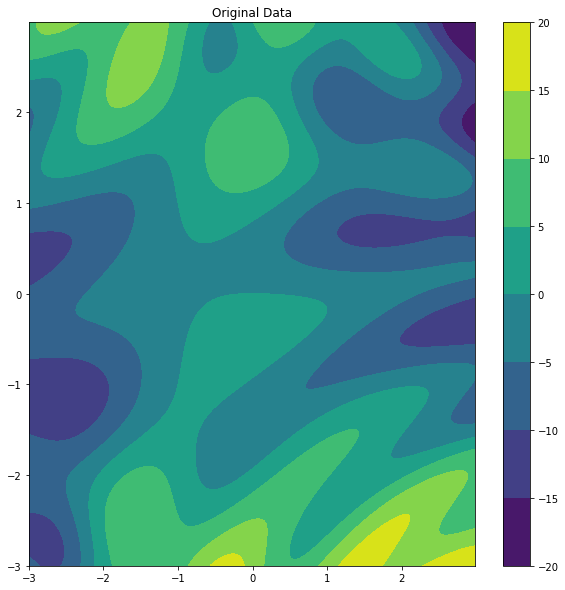

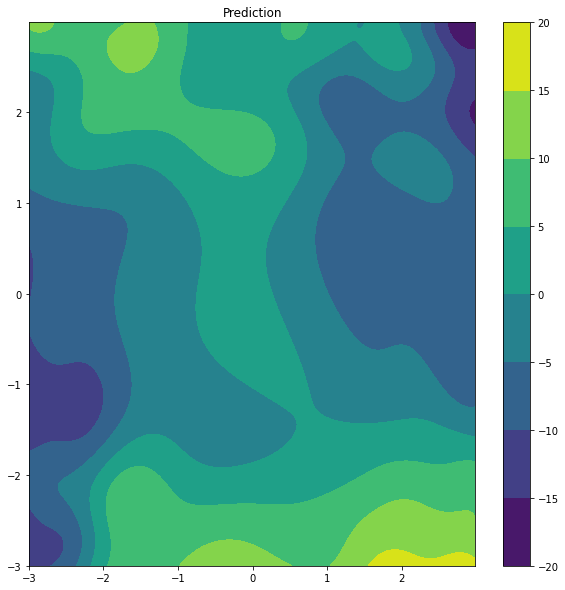

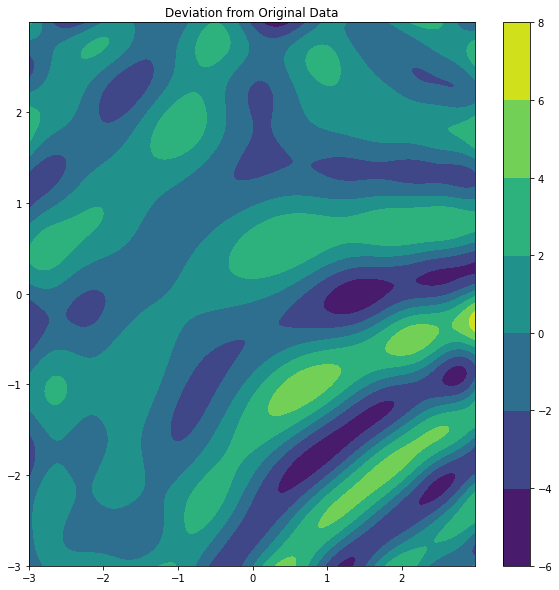

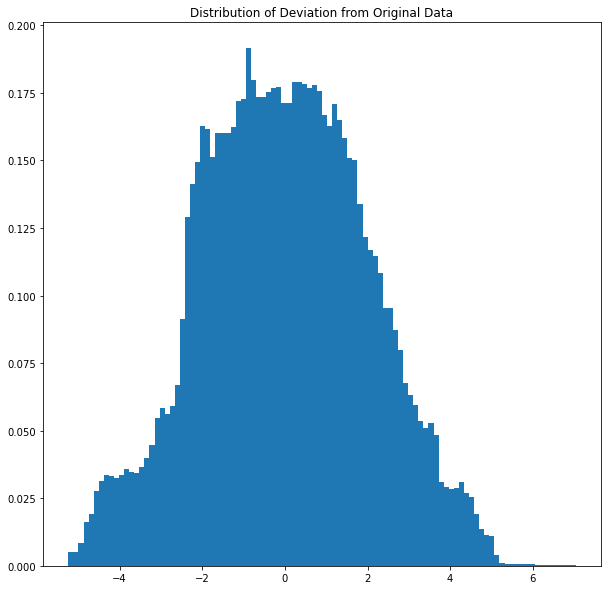

In [5]:
# plot
data.plot_function()
prediction = model.predict(data.grid_input)
prediction = prediction.reshape(*data.x.shape)

plt.figure(figsize=(10, 10))
plt.contourf(data.x, data.y, prediction)
plt.colorbar()
plt.title('Prediction')
plt.show()

plt.figure(figsize=(10, 10))
plt.contourf(data.x, data.y, prediction - data.z)
plt.colorbar()
plt.title('Deviation from Original Data')
plt.show()

plt.figure(figsize=(10, 10))
plt.hist((prediction - data.z).reshape(-1), bins=100, density=True)
plt.title('Distribution of Deviation from Original Data')
plt.show()
